In [ ]:
!pip install pyarrow

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [12]:
root_data_url = "https://github.com/muziejus/coms-w4995-applied-machine-learning-project/raw/refs/heads/main/data"
companies = ['DLTR', 'LULU', 'ULTA', 'WBA', 'WMT']
dataframes = []
for company in companies:
    df = pd.read_parquet(f"{root_data_url}/{company.lower()}_merged_data.parquet")
    df['Month'] = df.index.month
    df['DayOfWeek'] = df.index.day_name()
    df['Company'] = company
    dataframes.append(df)

org_df = pd.concat(dataframes)
print(org_df.columns)

Index(['analyzed_bpe_tokens', 'weighted_sentiment', 'weighted_error',
       'analyzed_naive_tokens', 'daily_naive_token_sum',
       'analyzed_article_count', 'daily_article_count',
       'sentiment_3d_rolling_mean', 'sentiment_7d_rolling_mean',
       'sentiment_14d_rolling_mean', 'cpi', 'pce', 'ppi', 'eci', 'gdp',
       'unemployment', 'manufacturing', 'sp500', 'open', 'high', 'low',
       'close', 'volume', 'dividends', 'stock_splits', 'price_3d_rolling_mean',
       'price_3d_rolling_std', 'volume_3d_rolling_mean',
       'volume_3d_rolling_std', 'bollinger_3d_upper_band',
       'bollinger_3d_lower_band', 'price_7d_rolling_mean',
       'price_7d_rolling_std', 'volume_7d_rolling_mean',
       'volume_7d_rolling_std', 'bollinger_7d_upper_band',
       'bollinger_7d_lower_band', 'price_14d_rolling_mean',
       'price_14d_rolling_std', 'volume_14d_rolling_mean',
       'volume_14d_rolling_std', 'bollinger_14d_upper_band',
       'bollinger_14d_lower_band', 'target', 'target_pric

In [13]:
missing_values = org_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

df = org_df.dropna()
print(f"{df.shape[0]}")

Missing values in each column:
 analyzed_bpe_tokens              0
weighted_sentiment               0
weighted_error                   0
analyzed_naive_tokens            0
daily_naive_token_sum            0
analyzed_article_count           0
daily_article_count              0
sentiment_3d_rolling_mean     3031
sentiment_7d_rolling_mean     3051
sentiment_14d_rolling_mean    3086
cpi                              0
pce                              0
ppi                              0
eci                              0
gdp                              0
unemployment                     0
manufacturing                    0
sp500                            5
open                          3290
high                          3290
low                           3290
close                         3290
volume                        3290
dividends                     3290
stock_splits                  3290
price_3d_rolling_mean         3300
price_3d_rolling_std          3300
volume_3d_rolling_mean 

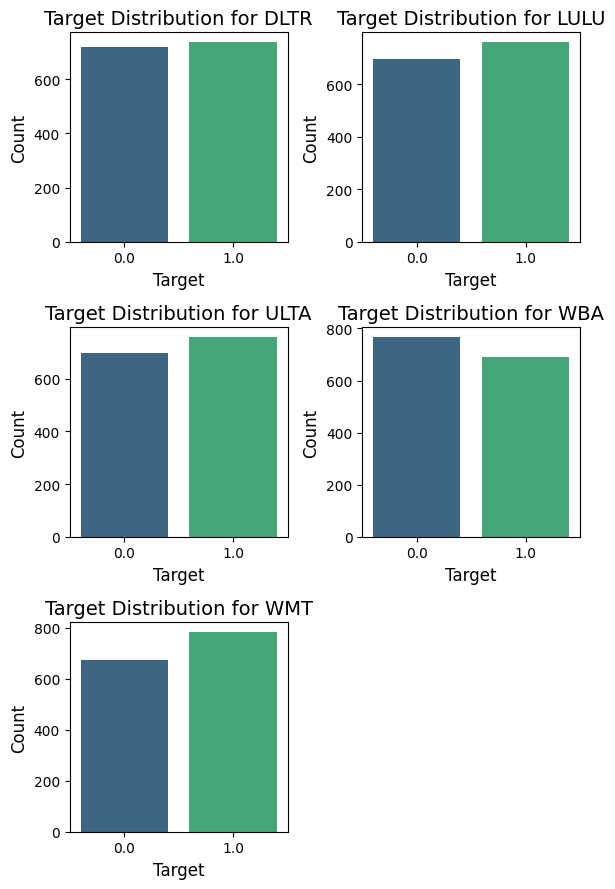

In [14]:
num_companies = len(companies)

fig, axes = plt.subplots(3, 2, figsize=(6, 9))
axes = axes.flatten()

for idx, company in enumerate(companies):
    ax = axes[idx]
    company_data = org_df[org_df['Company'] == company]
    sns.countplot(x='target', data=company_data, ax=ax, hue='target', palette='viridis', legend=False)
    ax.set_title(f'Target Distribution for {company.upper()}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

for idx in range(len(companies), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# SVM Model

In [17]:
class SVMAnalyzer:
    def __init__(self):
        pass

    def fit(self, df):
        X = df.drop('target', axis=1)
        y = df['target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        categorical_features = ['Month', 'DayOfWeek', 'Company']
        numerical_features = X.columns.drop(categorical_features)
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ]
        )
        self.pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', SVC(kernel='rbf', random_state=42))
        ])
        self.pipeline.fit(X_train, y_train)
        self.X_test = X_test
        self.y_test = y_test
        return X_test, y_test

    def get_feature_importance(self):
        # Calculate permutation importance
        perm_importance = permutation_importance(
            self.pipeline, self.X_test, self.y_test, n_repeats=10, random_state=42
        )
        feature_names = list(self.X_test.columns)
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)
        return importance_df

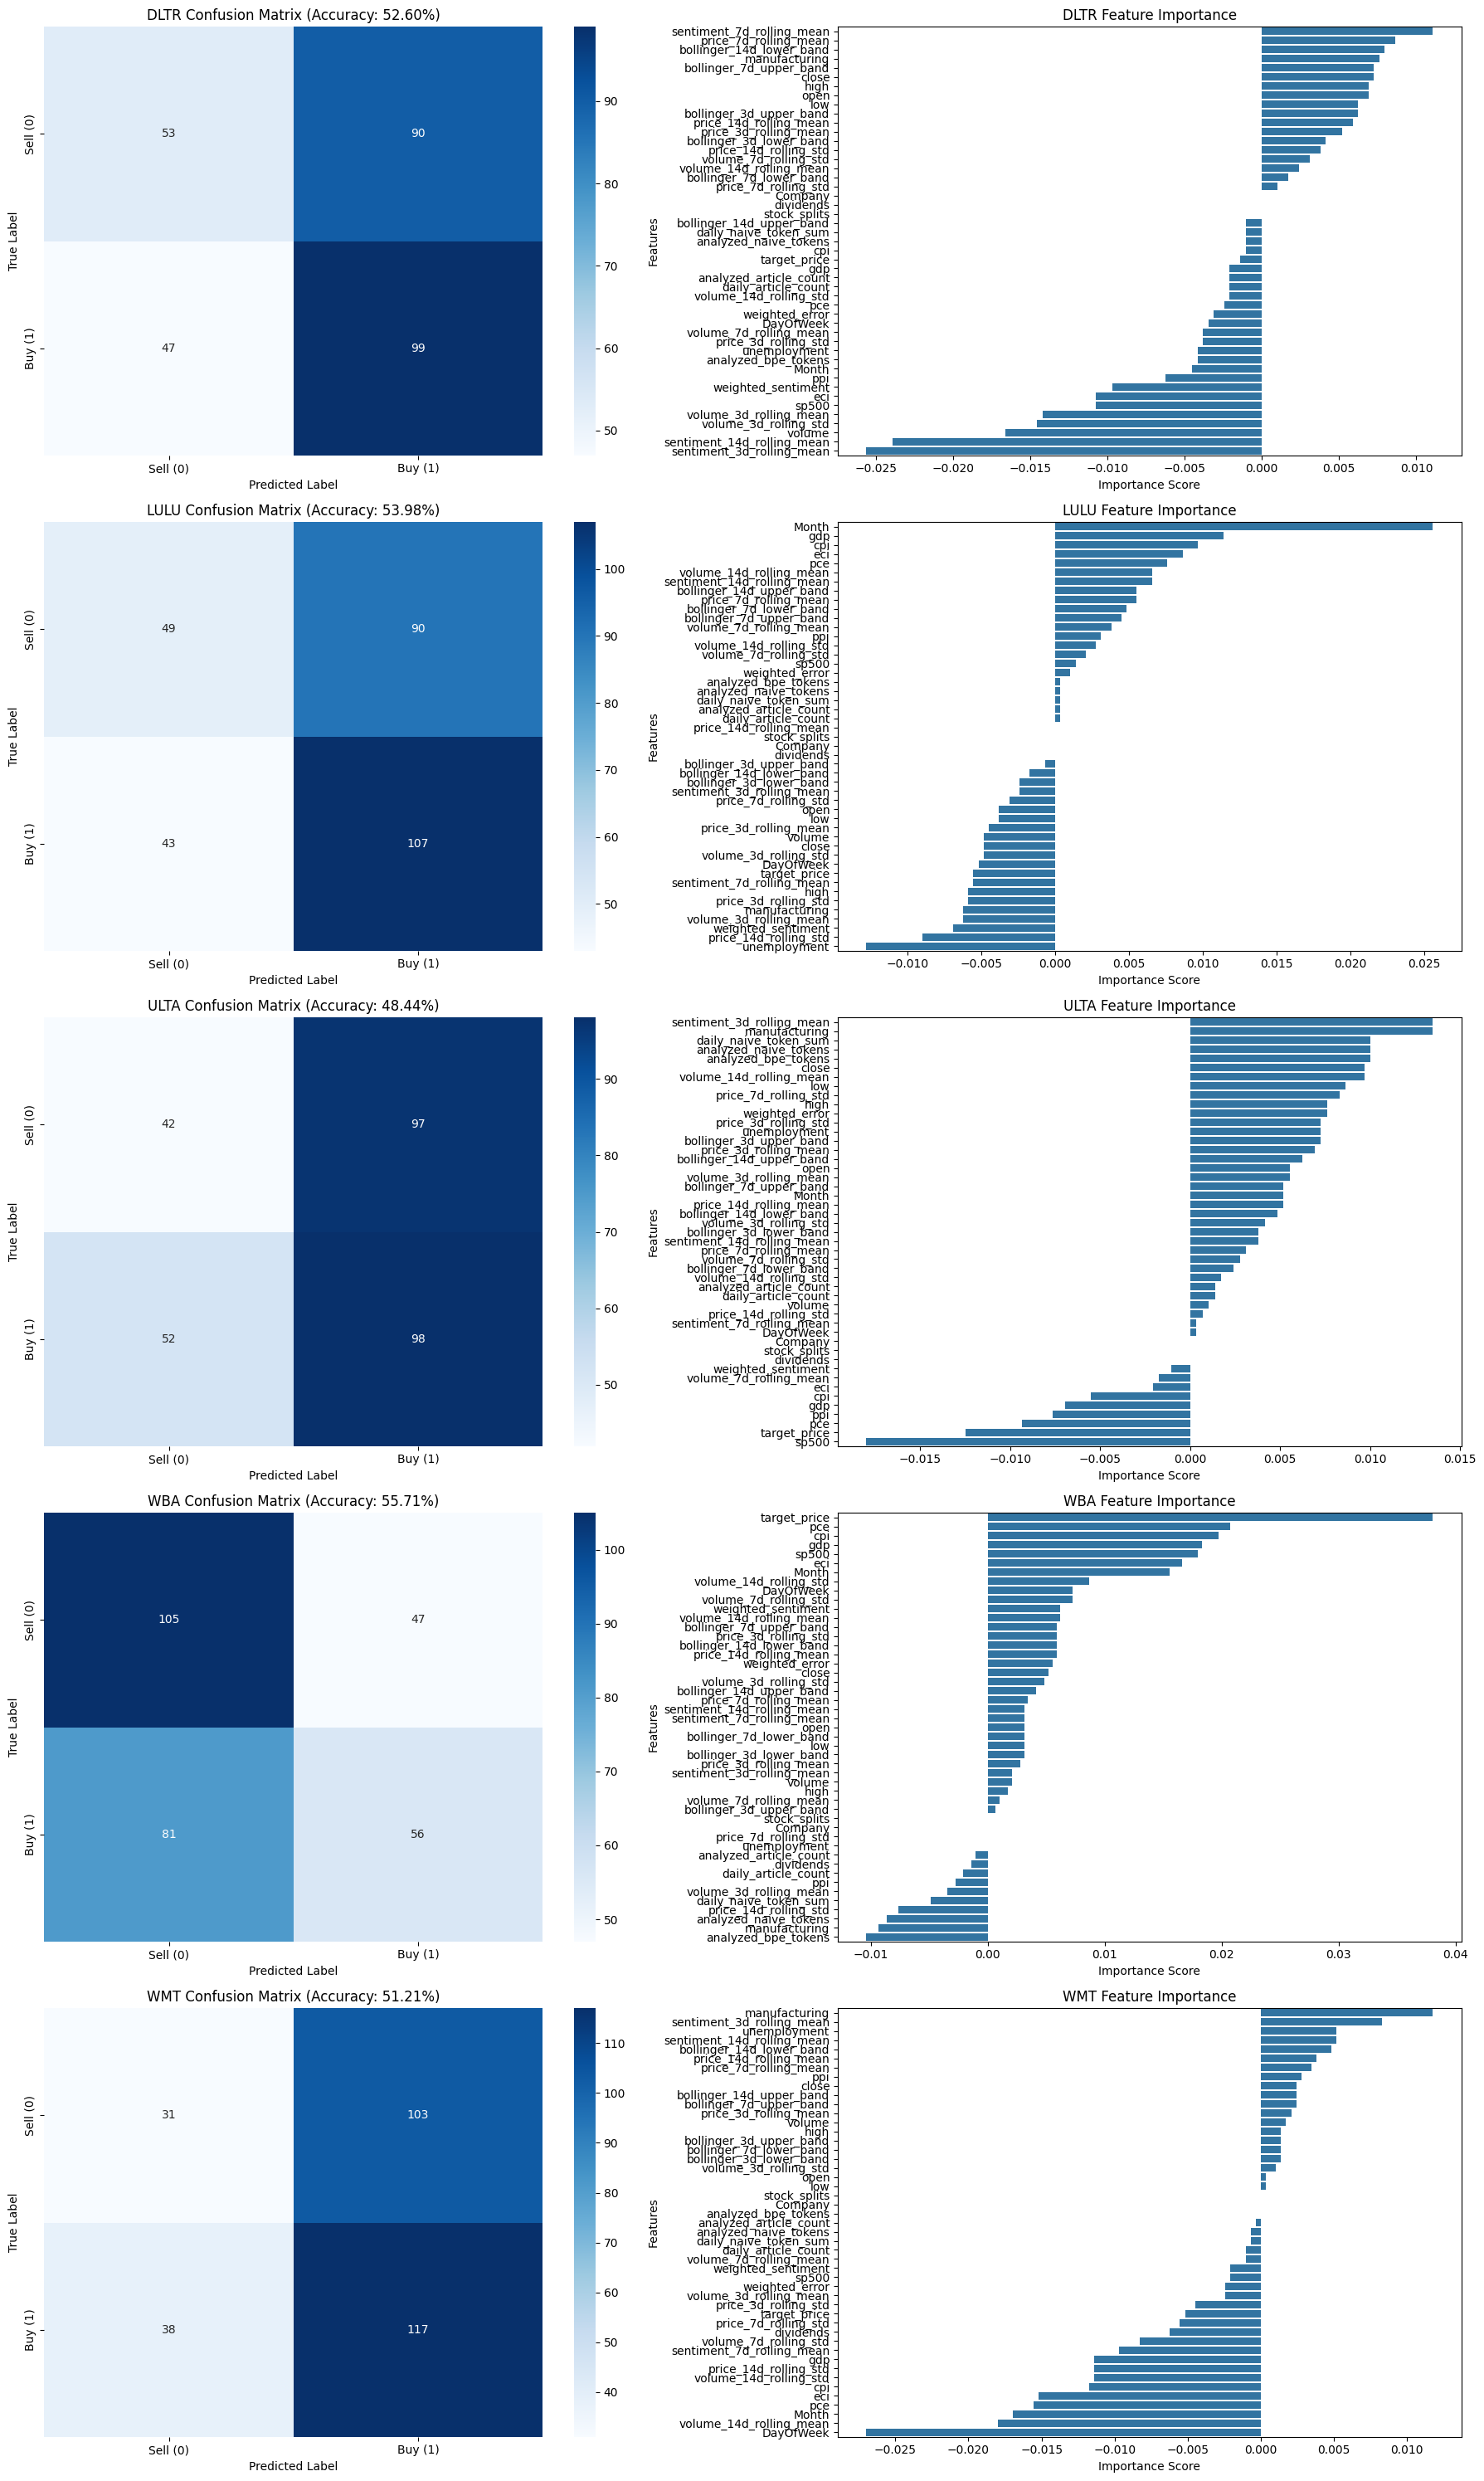

In [18]:
fig, axes = plt.subplots(len(companies), 2, figsize=(18, 6 * len(companies)))

for idx, company in enumerate(companies):
    analyzer = SVMAnalyzer()
    company_df = df[df['Company'] == company]
    X_test, y_test = analyzer.fit(company_df)
    y_pred = analyzer.pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Subplot 1: Confusion Matrix
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Sell (0)', 'Buy (1)'],
        yticklabels=['Sell (0)', 'Buy (1)'],
        ax=axes[idx, 0]
    )
    axes[idx, 0].set_xlabel('Predicted Label')
    axes[idx, 0].set_ylabel('True Label')
    axes[idx, 0].set_title(f'{company.upper()} Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')

    # Subplot 2: Feature Importance
    feature_importance = analyzer.get_feature_importance()
    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_importance,
        ax=axes[idx, 1]
    )
    axes[idx, 1].set_title(f'{company.upper()} Feature Importance')
    axes[idx, 1].set_xlabel('Importance Score')
    axes[idx, 1].set_ylabel('Features')

# Adjust layout
plt.tight_layout()
plt.show()

# XGBoost Model

In [19]:
class XGBoostAnalyzer:
    def __init__(self):
        pass
    def fit(self, df):
        X = df.drop('target', axis=1)
        y = df['target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        categorical_features = ['Month', 'DayOfWeek', 'Company']
        numerical_features = X.columns.drop(categorical_features)
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ]
        )
        # Create the pipeline with preprocessor and classifier
        self.pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42,
                eval_metric='logloss'
            ))
        ])
        self.pipeline.fit(X_train, y_train)
        self.X_test = X_test
        self.y_test = y_test
        return X_test, y_test

    def get_feature_importance(self):
        # Calculate permutation importance
        perm_importance = permutation_importance(
            self.pipeline, self.X_test, self.y_test, n_repeats=10, random_state=42
        )
        feature_names = list(self.X_test.columns)
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)
        return importance_df

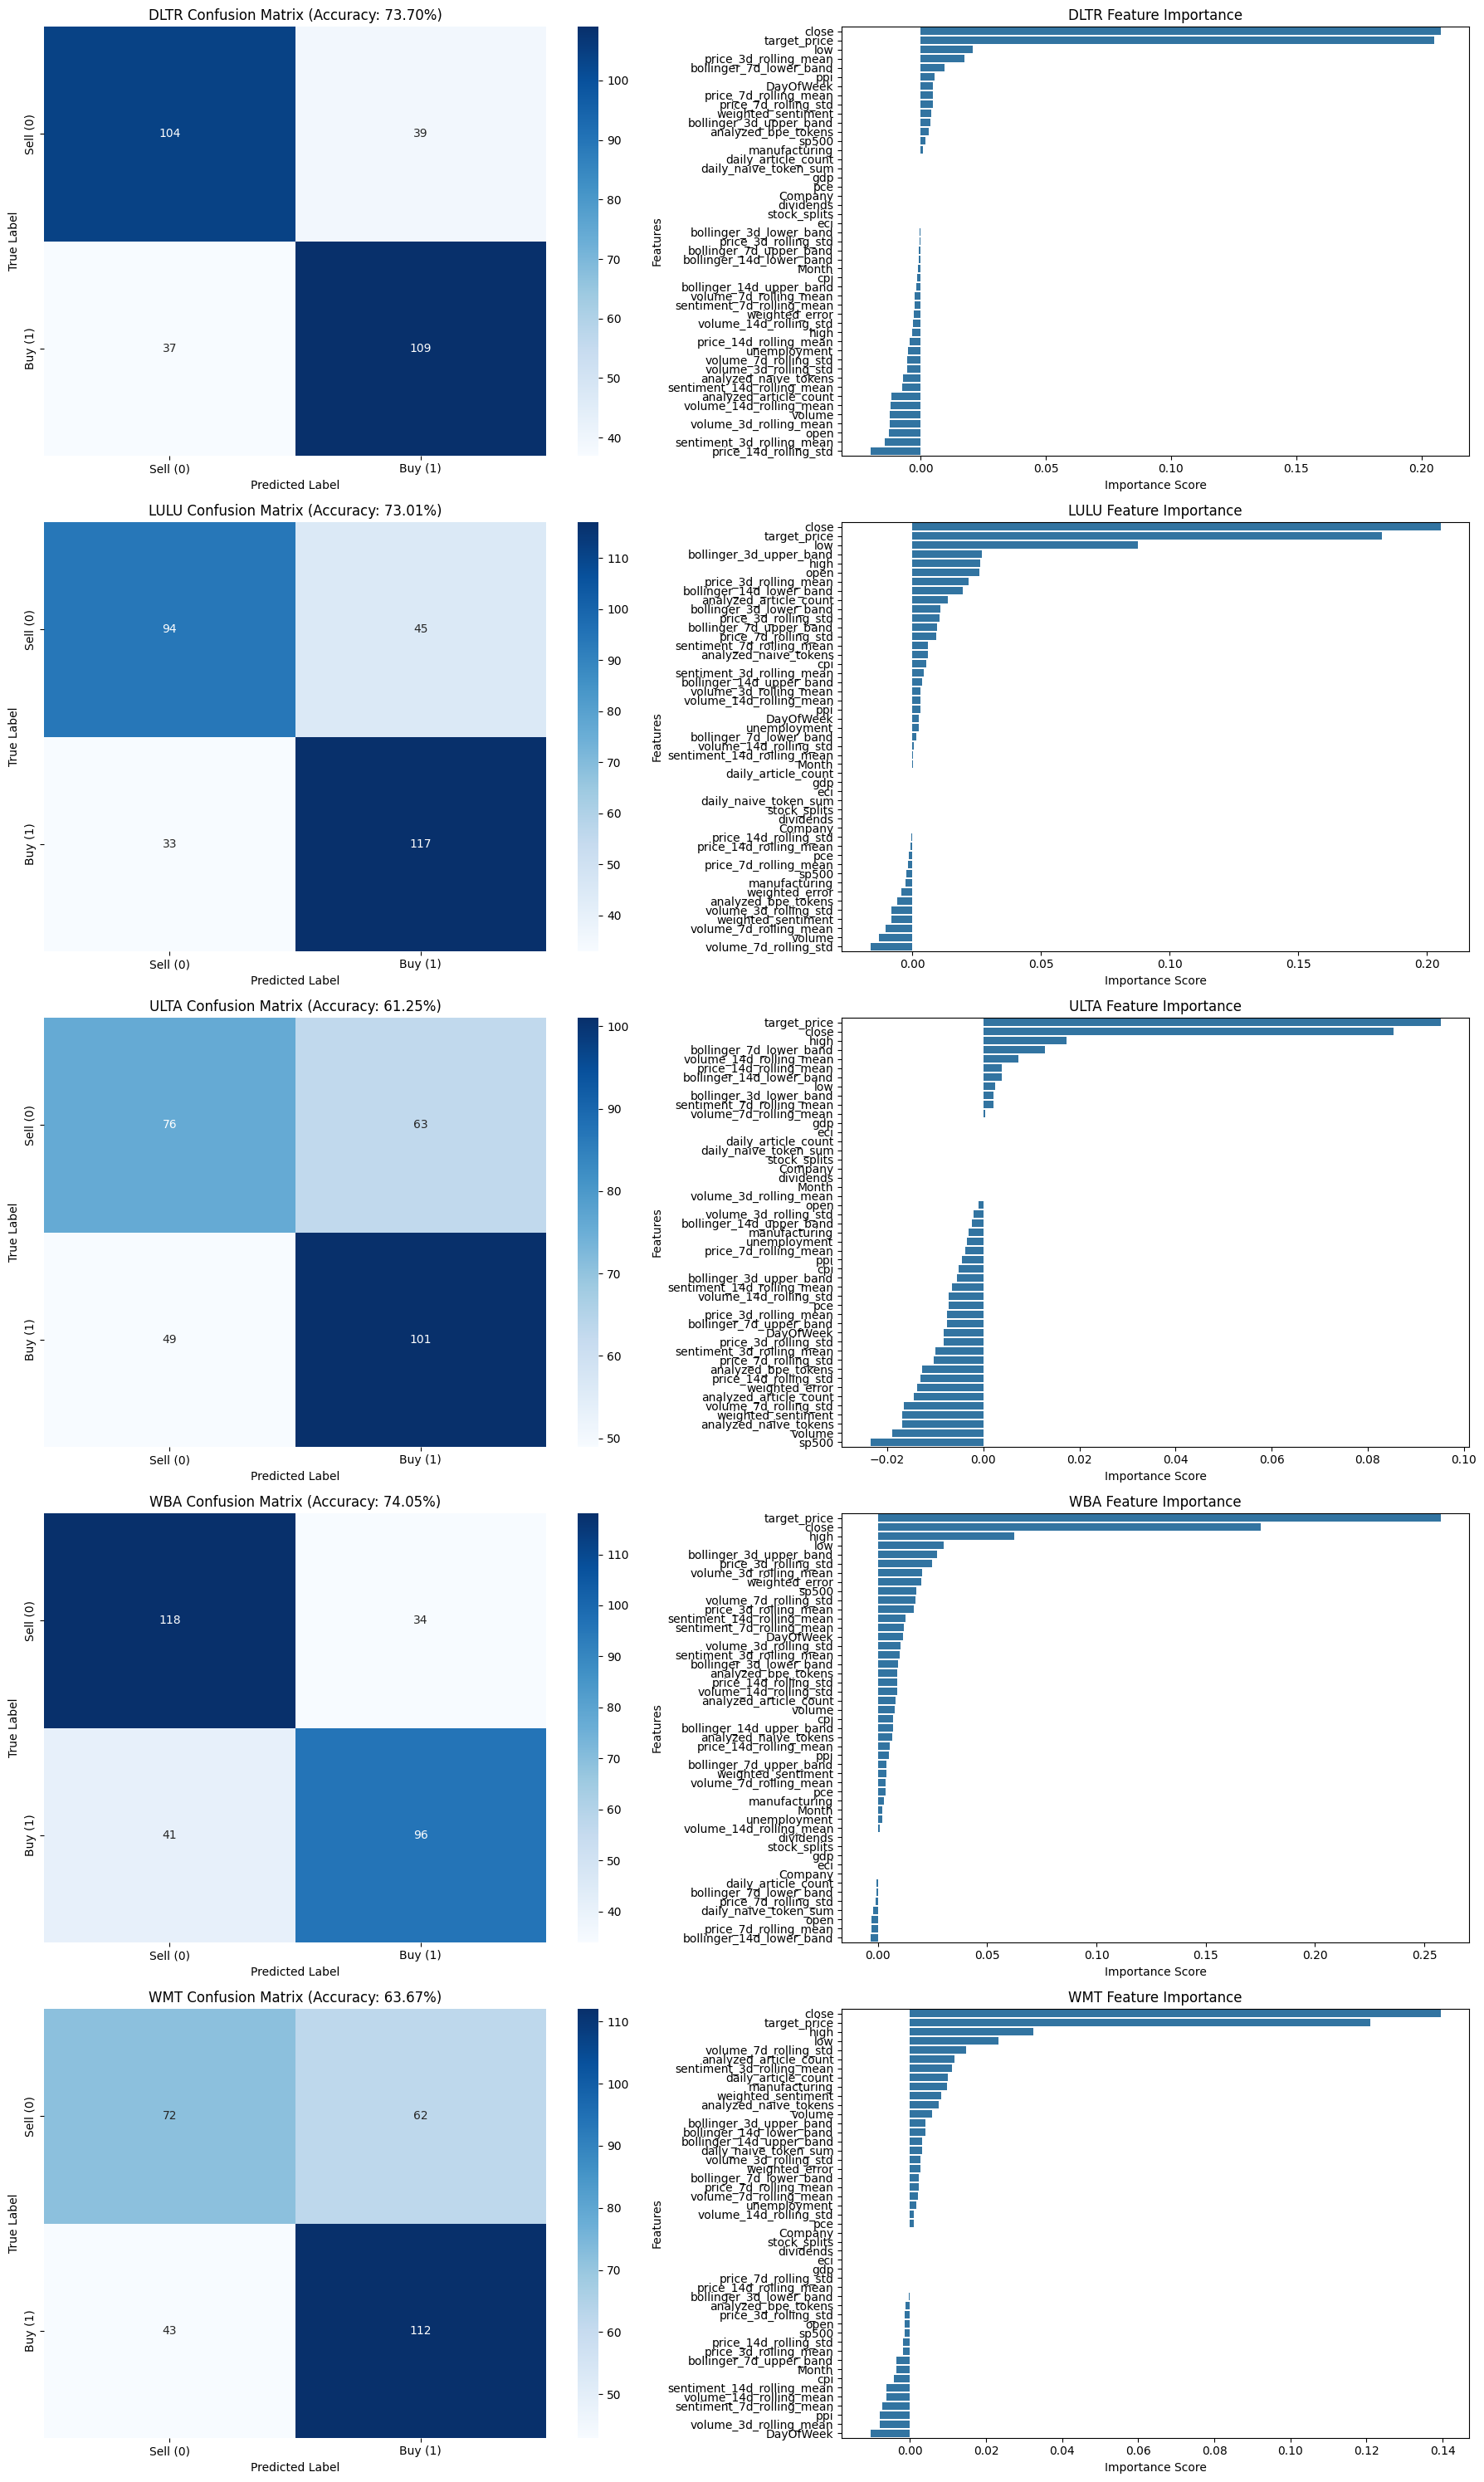

In [20]:
fig, axes = plt.subplots(len(companies), 2, figsize=(18, 6 * len(companies)))

for idx, company in enumerate(companies):
    analyzer = XGBoostAnalyzer()
    company_df = df[df['Company'] == company]
    X_test, y_test = analyzer.fit(company_df)
    y_pred = analyzer.pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Subplot 1: Confusion Matrix
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Sell (0)', 'Buy (1)'],
        yticklabels=['Sell (0)', 'Buy (1)'],
        ax=axes[idx, 0]
    )
    axes[idx, 0].set_xlabel('Predicted Label')
    axes[idx, 0].set_ylabel('True Label')
    axes[idx, 0].set_title(f'{company.upper()} Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')

    # Subplot 2: Feature Importance
    feature_importance = analyzer.get_feature_importance()
    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_importance,
        ax=axes[idx, 1]
    )
    axes[idx, 1].set_title(f'{company.upper()} Feature Importance')
    axes[idx, 1].set_xlabel('Importance Score')
    axes[idx, 1].set_ylabel('Features')

# Adjust layout
plt.tight_layout()
plt.show()